In [1]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *
from scipy.ndimage.filters import uniform_filter1d
from sklearn import linear_model

In [2]:
n_seeds = 12
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
difficulties = [8, 12, 16, 20, 32, 64, 128, 256]
T_horizons = list(range(10))
macro_configs = config_generator(algorithm=['BPTT'],
                                 difficulty=difficulties,
                                 T_horizon=T_horizons)
micro_configs = tuple(product(macro_configs, list(range(n_seeds))))

params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds
np.random.seed(i_job)

In [ ]:
params['task'] = 'Mimic'
params['alpha'] = 0.5
params['latent_dim'] = None

alpha = params['alpha']

if params['alpha'] == 1:
    n_1, n_2 = 22, 24
    tau_task = 1
if params['alpha'] == 0.5:
    n_1, n_2 = 2, 4
    tau_task = 2

if params['task'] == 'Mimic':

    n_in = 32
    n_hidden = params['difficulty']
    n_out = 32

    W_in_target  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
    W_rec_target = np.linalg.qr(np.random.normal(0, 1, (n_hidden, n_hidden)))[0]
    #W_rec_target *= (0.5 + 0.1 * params['difficulty'])
    W_out_target = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))
    b_rec_target = np.random.normal(0, 0.1, n_hidden)
    b_out_target = np.random.normal(0, 0.1, n_out)

    alpha = params['alpha']

    rnn_target = RNN(W_in_target, W_rec_target, W_out_target,
                     b_rec_target, b_out_target,
                     activation=tanh,
                     alpha=alpha,
                     output=identity,
                     loss=mean_squared_error)

    task = Mimic_RNN(rnn_target, p_input=0.5, tau_task=tau_task,
                     latent_dim=params['latent_dim'])

elif params['task'] == 'Add':

    n_1 = params['difficulty']
    n_2 = params['difficulty'] + 2
    task = Add_Task(n_1, n_2, deterministic=True, tau_task=tau_task)

data = task.gen_data(100000, 5000)

n_in = task.n_in
n_hidden = 32
n_out = task.n_out

W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = np.linalg.qr(np.random.normal(0, 1, (n_hidden, n_hidden)))[0]
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))
W_FB = np.random.normal(0, np.sqrt(1/n_out), (n_out, n_hidden))
b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = params['alpha']

if params['task'] == 'Add':
    rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
              activation=tanh,
              alpha=alpha,
              output=softmax,
              loss=softmax_cross_entropy)

if params['task'] == 'Mimic':
    rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
              activation=tanh,
              alpha=alpha,
              output=identity,
              loss=mean_squared_error)

optimizer = Stochastic_Gradient_Descent(lr=0.001)
SG_optimizer = Stochastic_Gradient_Descent(lr=0.001)
if params['alpha'] == 1 and params['task'] == 'Add':
    SG_optimizer = Stochastic_Gradient_Descent(lr=0.05)

if params['algorithm'] == 'Only_Output_Weights':
    learn_alg = Only_Output_Weights(rnn)
if params['algorithm'] == 'RTRL':
    learn_alg = RTRL(rnn)
if params['algorithm'] == 'UORO':
    learn_alg = UORO(rnn)
if params['algorithm'] == 'KF-RTRL':
    learn_alg = KF_RTRL(rnn)
if params['algorithm'] == 'R-KF-RTRL':
    learn_alg = Reverse_KF_RTRL(rnn)
if params['algorithm'] == 'BPTT':
    learn_alg = Future_BPTT(rnn, params['T_horizon'])
if params['algorithm'] == 'DNI':
    learn_alg = DNI(rnn, SG_optimizer)
if params['algorithm'] == 'DNIb':
    J_lr = 0.001
    if params['alpha'] == 1 and params['task'] == 'Add':
        J_lr = 0.01
    learn_alg = DNI(rnn, SG_optimizer, use_approx_J=True, J_lr=J_lr,
                    SG_label_activation=tanh, W_FB=W_FB)
    learn_alg.name = 'DNIb'
if params['algorithm'] == 'RFLO':
    learn_alg = RFLO(rnn, alpha=alpha)
if params['algorithm'] == 'KeRNL':
    sigma_noise = 0.0000001
    base_learning_rate = 0.01
    kernl_lr = base_learning_rate/sigma_noise
    KeRNL_optimizer = Stochastic_Gradient_Descent(kernl_lr)
    learn_alg = KeRNL(rnn, KeRNL_optimizer, sigma_noise=sigma_noise)

comp_algs = []
monitors = []

sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        comp_algs=comp_algs,
        monitors=monitors,
        verbose=True,
        report_accuracy=False,
        report_loss=True)

#Get validation losses
np.random.seed(1)
n_test = 10000
data = task.gen_data(0, n_test)
test_sim = deepcopy(sim)
test_sim.run(data,
             mode='test',
             monitors=['rnn.loss_'],
             verbose=False)
processed_data = np.mean(test_sim.mons['rnn.loss_'])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sim, 'i_seed': i_seed, 'task': task,
          'config': params, 'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [3]:
###Truncate file above
file_name = 'Supplemental_Fig_BPTT'
job_name = 'corr_mimic_BPTT_alpha05'
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py ../../cluster_main_scripts/{}.py'.format(file_name, job_name))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook Supplemental_Fig_BPTT.ipynb to script
[NbConvertApp] Writing 9419 bytes to Supplemental_Fig_BPTT.py
awk: 1: unexpected character '.'


In [4]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name))
job_id_1 = submit_job('../job_scripts/{}.s'.format(job_name), n_jobs)

rm: cannot remove '/scratch/oem214/learning-dynamics/results/corr_mimic_BPTT_alpha05/result_*': No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/test.py
vanilla-rtrl/test_2.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/.ipynb_checkpoints/test_interface-checkpoint.ipynb
vanilla-rtrl/__pycache__/
vanilla-rtrl/__pycache__/analysis.cpython-36.pyc
vanilla-rtrl/__pycache__/analysis_funcs.cpython-36.pyc
vanilla-rtrl/__pycache__/analysi

vanilla-rtrl/learning_algorithms/Efficient_BPTT.py
vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Reverse_KF_RTRL.py
vanilla-rtrl/learning_algorithms/Stochastic_Algorithm.py
vanilla-rtrl/learning_algorithms/UORO.py
vanilla-rtrl/learning_algorithms/__init__.py
vanilla-rtrl/learning_algorithms/__pycache__/
vanilla-rtrl/learning_algorithms/__pycache__/DNI.cpython-37.pyc
vanilla-rtrl/learning_algorithms/__pycache__/DNI.cpython-38.pyc
vanilla-rtrl/learning_algorithms/__pycach

In [10]:
###Get job status
get_ipython().system('squeue -u oem214')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          11063771        cm  jupyter   oem214  R      37:11      1 cm12


In [11]:
job_name = 'corr_mimic_BPTT_alpha05'

In [12]:
configs_array, results_array, key_order, sim_dict = unpack_processed_data('../job_scripts/{}.s'.format(job_name))

In [13]:
def get_mean_and_ste_curves(results, scalar=True):

    if scalar:
        N_missing = (results==0).sum()
    else:
        N_missing = (results==0).sum()/results.shape[-1]
        
    print('Number of missing cases = {}\n'.format(N_missing))
    
    print('Replacing 0s with nan\n')
    
    results[np.where(results==0)] = np.nan
    
    results = np.squeeze(results)
    if scalar:
        mean_results = np.nanmean(results, -1)
        std_results = np.nanstd(results, -1)
        N_results = (~np.isnan(results)).sum(-1)
        ste_results = std_results/np.sqrt(N_results)
    else:
        mean_results = np.nanmean(results, -2)
        std_results = np.nanstd(results, -2)
        N_results = (~np.isnan(results)).sum(-2)
        ste_results = std_results/np.sqrt(N_results)

    return mean_results, ste_results

In [15]:
mean_results, ste_results = get_mean_and_ste_curves(results_array)

Number of missing cases = 0

Replacing 0s with nan



In [18]:
import matplotlib as mpl
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

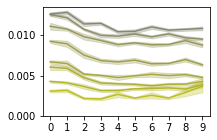

In [22]:
fig = plt.figure(figsize=(3, 2))
for i in range(8):
    
    x = configs_array['T_horizon']
    mu = mean_results[i]
    sigma = ste_results[i]
    #plt.plot(x, mu, color=str(-i/10 + 0.8))
    col = colorFader('C8', str(0.5), i/8)
    plt.plot(x, mu, color=col)
    plt.fill_between(x, mu - sigma, mu + sigma, color=col, alpha=0.3)
    
plt.ylim([0, 0.0135])
plt.xticks(configs_array['T_horizon'])
fig_name = 'S2d_raw_alpha05_2.pdf'
fig.savefig(os.path.join('figs', fig_name), dpi=300, format='pdf')